# Setup

In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Perceptrons

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
#!pip install sklearn

In [4]:
y_pred

array([1])

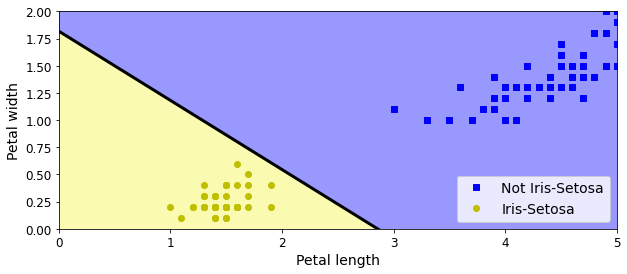

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

# Activation functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

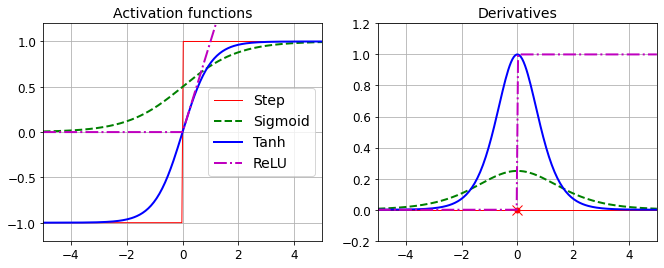

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

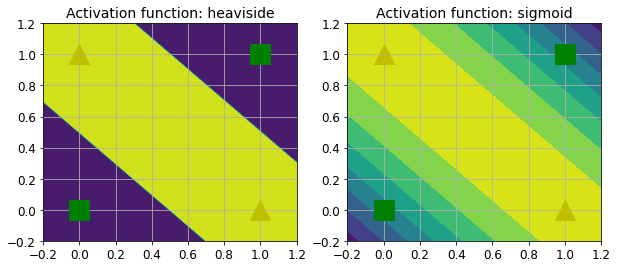

In [9]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
tf.__version__

'2.3.1'

In [12]:
keras.__version__

'2.4.0'

- 패션 MNIST 데이터 세트를 로딩하고, 
- `keras.datasets` 함수를 이용하여 데이터를 올림. 
- 데이터는 이미 훈련과 테스트로 나누어 지고, 검증을 위해 분할도 가능

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- 훈련 데이터는 60,000개의 회색 이미지로 크기는 28x28 픽셀이다.

In [14]:
X_train_full.shape

(60000, 28, 28)

- 각 픽셀 강도는 1바이트로 표시
- 참고로 1바이트는 8비트이고, 1비트는 0, 1이 있다
- 따라서 1byte=8bit=$2^8$으로 (0 to 255):

In [15]:
X_train_full.dtype

dtype('uint8')

- 훈련 데이터를 검증 데이터 세트로 나누고
- 각 픽셀의 강도를 0~1로 스케일 하고, 정수를 부동소수점으로 바꿔줌


In [16]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

- Matplotlib의 `imshow()`함수 및 `'binary'` 컬러 맵을 보자 

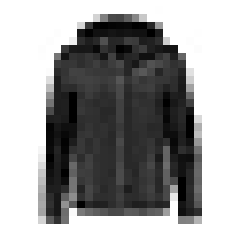

In [17]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

- 라벨은 10개 범주로 0에서 9까지 숫자로 표시 

In [18]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

- 각 법주의 이름(택)을 지어주면

In [19]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

- 훈련 데이터의 첫번째 이미지의 범주는 코트
- 1번째 이미지는 T-Shirt

In [20]:
class_names[y_train[1]]

'T-shirt/top'

- 검증 데이터 크기

In [21]:
X_train.shape

(55000, 28, 28)

In [22]:
X_valid.shape

(5000, 28, 28)

In [23]:
X_test.shape

(10000, 28, 28)

- 데이터에 있는 샘플 이미지들 살펴보자 

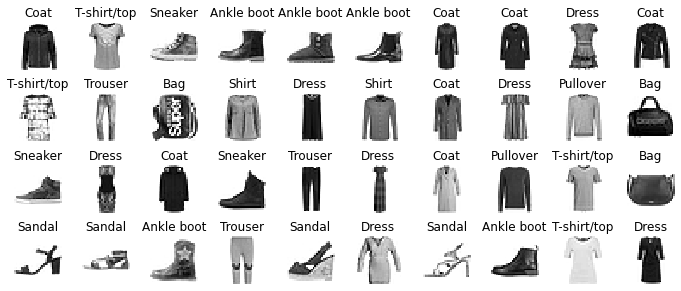

In [24]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

In [25]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation="relu"))

model.add(keras.layers.Dense(100, activation="relu"))

model.add(keras.layers.Dense(10, activation="softmax"))

In [26]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.layers

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [30]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
#!conda list


In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer(hidden1.name) is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()

In [35]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [36]:
weights.shape

(784, 300)

In [37]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
biases.shape

(300,)

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [40]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4842 - accuracy: 0.8316 - val_loss: 0.4351 - val_accuracy: 0.8514
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4391 - accuracy: 0.8455 - val_loss: 0.5269 - val_accuracy: 0.8008
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4123 - accuracy: 0.8567 - val_loss: 0.3915 - val_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3939 - accuracy: 0.8620 - val_loss: 0.3746 - val_accuracy: 0.8694
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3750 - accuracy: 0.8675 - val_loss: 0.3710 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3630 - accuracy: 0.8713 - val_loss: 0.3617 - val_accuracy:

In [41]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

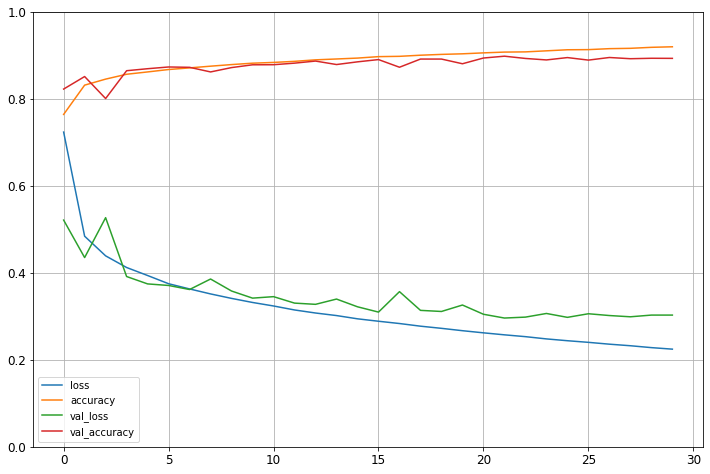

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [45]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 736us/step - loss: 0.3366 - accuracy: 0.8826


[0.3366280198097229, 0.8826000094413757]

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [47]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1], dtype=int64)

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

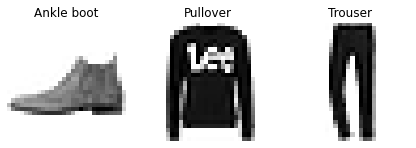

In [50]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 797us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 621us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 604us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 610us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 615us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 613us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 709us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 596us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 607us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 593us/step - loss: 0.487

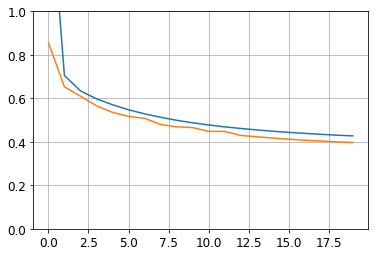

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [58]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]         

In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 887us/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 692us/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 701us/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 681us/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 736us/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 775us/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 668us/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 690us/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 745us/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 684us/step - loss: 0.465

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [62]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 0s 901us/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 742us/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 849us/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 758us/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 745us/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 764us/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 819us/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 728us/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 731us/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 805us/step - loss: 0.464

Adding an auxiliary output for regularization:

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [65]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [66]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 923us/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 876us/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 918us/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 959us/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - 

In [67]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 616us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# The subclassing API

In [68]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [69]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 885us/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 967us/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 0s 857us/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 0s 885us/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.596

In [70]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [73]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 868us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 769us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 714us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 665us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 747us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 651us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 717us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 679us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 703us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 480us/step - loss: 0.438

In [74]:
model.save("my_keras_model.h5")

In [75]:
model = keras.models.load_model("my_keras_model.h5")

In [76]:
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.0098243]], dtype=float32)

In [77]:
model.save_weights("my_keras_weights.ckpt")

In [78]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [81]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 887us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 799us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 709us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 687us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 775us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 690us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 709us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 728us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 725us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 456us/step - loss: 0.438

In [82]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 953us/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 775us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 745us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 728us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 698us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 736us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 731us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 742us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 703us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 794us/step - l

Epoch 80/100
363/363 [==============================] - 0s 703us/step - loss: 0.3329 - val_loss: 0.3354
Epoch 81/100
363/363 [==============================] - 0s 651us/step - loss: 0.3324 - val_loss: 0.3274
Epoch 82/100
363/363 [==============================] - 0s 637us/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 0s 657us/step - loss: 0.3317 - val_loss: 0.3280
Epoch 84/100
363/363 [==============================] - 0s 712us/step - loss: 0.3312 - val_loss: 0.3634
Epoch 85/100
363/363 [==============================] - 0s 662us/step - loss: 0.3310 - val_loss: 0.3176
Epoch 86/100
363/363 [==============================] - 0s 676us/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 0s 662us/step - loss: 0.3305 - val_loss: 0.3529
Epoch 88/100
363/363 [==============================] - 0s 717us/step - loss: 0.3299 - val_loss: 0.3258
Epoch 89/100
363/363 [==============================] - 0s 673us

In [83]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [84]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

316/363 [=========================>....] - ETA: 0s - loss: 0.3297
val/train: 1.08
363/363 [==============================] - 0s 827us/step - loss: 0.3302 - val_loss: 0.3556


# TensorBoard

In [85]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [86]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_12_14-18_31_31'

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [89]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 7.8215WARNING:tensorflow:From c:\users\admin\.conda\envs\tf2.3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 1s 3ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 838us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 846us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 921us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 885us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 788us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [===============

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [90]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5444.

In [91]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2020_12_14-18_32_41'

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [94]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5530 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 0s 901us/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 885us/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 885us/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 896us/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 876us/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 0s 887us/step - loss: 1.3425 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 0s 896us/step - loss: 1.3433 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 0s 871us/step - loss: 1.3435 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 0s 918us/step - lo

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [95]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [96]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [97]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    
    model.compile(loss="mse", optimizer=optimizer)
    
    return model

In [98]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [99]:
keras_reg.fit(X_train, y_train, epochs=20,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
363/363 [==============================] - 0s 885us/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/20
363/363 [==============================] - 0s 706us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/20
363/363 [==============================] - 0s 739us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/20
363/363 [==============================] - 0s 712us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/20
363/363 [==============================] - 0s 744us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/20
363/363 [==============================] - 0s 764us/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/20
363/363 [==============================] - 0s 728us/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/20
363/363 [==============================] - 0s 755us/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/20
363/363 [==============================] - 0s 712us/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/20
363/363 [==============================] - 0s 687us/step - loss: 0.40

In [100]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 529us/step - loss: 0.3749


In [101]:
y_pred = keras_reg.predict(X_new)

In [102]:
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 40),
    "learning_rate": [0.1, 0.01]
#        "learning_rate": reciprocal(3e-4, 3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

rnd_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=34, n_hidden=1, learning_rate=0.01 ....................
Epoch 1/20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 0s 1ms/step - loss: 0.8699 - val_loss: 14.1421
Epoch 2/20
242/242 [==============================] - 0s 832us/step - loss: 0.6112 - val_loss: 22.3404
Epoch 3/20
242/242 [==============================] - 0s 890us/step - loss: 0.6373 - val_loss: 0.4415
Epoch 4/20
242/242 [==============================] - 0s 882us/step - loss: 0.4486 - val_loss: 0.3982
Epoch 5/20
242/242 [==============================] - 0s 878us/step - loss: 0.4313 - val_loss: 0.3892
Epoch 6/20
242/242 [==============================] - 0s 853us/step - loss: 0.4113 - val_loss: 0.3800
Epoch 7/20
242/242 [==============================] - 0s 886us/step - loss: 0.4032 - val_loss: 0.3716
Epoch 8/20
242/242 [==============================] - 0s 886us/step - loss: 0.3949 - val_loss: 0.3636
Epoch 9/20
242/242 [==============================] - 0s 911us/step - loss: 0.3931 - val_loss: 0.3690
Epoch 10/20
242/242 [==============================] - 0s 894us/step - loss: 0.3878 - val_los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


242/242 [==============================] - 0s 1ms/step - loss: 0.8421 - val_loss: 0.5501
Epoch 2/20
242/242 [==============================] - 0s 882us/step - loss: 0.4972 - val_loss: 0.5846
Epoch 3/20
242/242 [==============================] - 0s 898us/step - loss: 0.4400 - val_loss: 0.4034
Epoch 4/20
242/242 [==============================] - 0s 894us/step - loss: 0.4225 - val_loss: 0.5141
Epoch 5/20
242/242 [==============================] - 0s 886us/step - loss: 0.4100 - val_loss: 0.7318
Epoch 6/20
242/242 [==============================] - 0s 898us/step - loss: 0.3983 - val_loss: 1.1515
Epoch 7/20
242/242 [==============================] - 0s 898us/step - loss: 0.3954 - val_loss: 1.5110
Epoch 8/20
242/242 [==============================] - 0s 874us/step - loss: 0.3861 - val_loss: 1.5409
Epoch 9/20
242/242 [==============================] - 0s 886us/step - loss: 0.3812 - val_loss: 1.8233
Epoch 10/20
242/242 [==============================] - 0s 845us/step - loss: 0.3786 - val_loss:

242/242 [==============================] - 0s 936us/step - loss: nan - val_loss: nan
Epoch 2/20
242/242 [==============================] - 0s 828us/step - loss: nan - val_loss: nan
Epoch 3/20
242/242 [==============================] - 0s 647us/step - loss: nan - val_loss: nan
Epoch 4/20
242/242 [==============================] - 0s 659us/step - loss: nan - val_loss: nan
Epoch 5/20
242/242 [==============================] - 0s 783us/step - loss: nan - val_loss: nan
Epoch 6/20
242/242 [==============================] - 0s 750us/step - loss: nan - val_loss: nan
Epoch 7/20
242/242 [==============================] - 0s 631us/step - loss: nan - val_loss: nan
Epoch 8/20
242/242 [==============================] - 0s 618us/step - loss: nan - val_loss: nan
Epoch 9/20
242/242 [==============================] - 0s 639us/step - loss: nan - val_loss: nan
Epoch 10/20
121/121 [==============================] - 0s 602us/step - loss: nan
[CV] ...... n_neurons=19, n_hidden=1, learning_rate=0.1, total=   

Epoch 5/20
242/242 [==============================] - 0s 659us/step - loss: nan - val_loss: nan
Epoch 6/20
242/242 [==============================] - 0s 713us/step - loss: nan - val_loss: nan
Epoch 7/20
242/242 [==============================] - 0s 758us/step - loss: nan - val_loss: nan
Epoch 8/20
242/242 [==============================] - 0s 705us/step - loss: nan - val_loss: nan
Epoch 9/20
242/242 [==============================] - 0s 668us/step - loss: nan - val_loss: nan
Epoch 10/20
121/121 [==============================] - 0s 371us/step - loss: nan
[CV] ...... n_neurons=22, n_hidden=1, learning_rate=0.1, total=   2.0s
[CV] n_neurons=26, n_hidden=0, learning_rate=0.1 .....................
Epoch 1/20
242/242 [==============================] - 0s 845us/step - loss: 10.3881 - val_loss: 3136.2104
Epoch 2/20
242/242 [==============================] - 0s 565us/step - loss: 13.1518 - val_loss: 206.2641
Epoch 3/20
242/242 [==============================] - 0s 614us/step - loss: 3.3088 - v

121/121 [==============================] - 0s 404us/step - loss: nan
[CV] ...... n_neurons=25, n_hidden=1, learning_rate=0.1, total=   2.3s
[CV] n_neurons=25, n_hidden=1, learning_rate=0.1 .....................
Epoch 1/20
242/242 [==============================] - 0s 894us/step - loss: 0.6381 - val_loss: 2.9437
Epoch 2/20
242/242 [==============================] - 0s 696us/step - loss: 0.4451 - val_loss: 1.1474
Epoch 3/20
242/242 [==============================] - 0s 664us/step - loss: 0.4071 - val_loss: 2.0737
Epoch 4/20
242/242 [==============================] - 0s 659us/step - loss: 0.3933 - val_loss: 0.8712
Epoch 5/20
242/242 [==============================] - 0s 680us/step - loss: 0.3834 - val_loss: 0.4137
Epoch 6/20
242/242 [==============================] - 0s 655us/step - loss: 0.3741 - val_loss: 0.3866
Epoch 7/20
242/242 [==============================] - 0s 705us/step - loss: 0.3652 - val_loss: 0.8101
Epoch 8/20
242/242 [==============================] - 0s 705us/step - loss:

121/121 [==============================] - 0s 428us/step - loss: 0.3263
[CV] ...... n_neurons=16, n_hidden=2, learning_rate=0.1, total=   4.0s
[CV] n_neurons=16, n_hidden=2, learning_rate=0.1 .....................
Epoch 1/20
242/242 [==============================] - 0s 977us/step - loss: 0.5709 - val_loss: 4.6234
Epoch 2/20
242/242 [==============================] - ETA: 0s - loss: 0.434 - 0s 758us/step - loss: 0.4331 - val_loss: 2.3783
Epoch 3/20
242/242 [==============================] - 0s 882us/step - loss: 0.4450 - val_loss: 4.5844
Epoch 4/20
242/242 [==============================] - 0s 738us/step - loss: 0.5108 - val_loss: 11.6053
Epoch 5/20
242/242 [==============================] - 0s 742us/step - loss: 0.4647 - val_loss: 0.4562
Epoch 6/20
242/242 [==============================] - 0s 709us/step - loss: 0.4877 - val_loss: 0.4429
Epoch 7/20
242/242 [==============================] - 0s 754us/step - loss: 0.4476 - val_loss: 0.3862
Epoch 8/20
242/242 [===========================

242/242 [==============================] - 0s 680us/step - loss: 0.3644 - val_loss: 0.4195
Epoch 9/20
242/242 [==============================] - 0s 692us/step - loss: 0.3581 - val_loss: 0.3576
Epoch 10/20
242/242 [==============================] - 0s 709us/step - loss: 0.3535 - val_loss: 0.4029
Epoch 11/20
242/242 [==============================] - 0s 664us/step - loss: 0.3514 - val_loss: 0.3381
Epoch 12/20
242/242 [==============================] - 0s 676us/step - loss: 0.3458 - val_loss: 0.3462
Epoch 13/20
242/242 [==============================] - 0s 725us/step - loss: 0.3427 - val_loss: 0.4336
Epoch 14/20
242/242 [==============================] - 0s 791us/step - loss: 0.3425 - val_loss: 0.3346
Epoch 15/20
242/242 [==============================] - 0s 684us/step - loss: 0.3377 - val_loss: 0.3791
Epoch 16/20
242/242 [==============================] - 0s 729us/step - loss: 0.3371 - val_loss: 0.3386
Epoch 17/20
242/242 [==============================] - 0s 680us/step - loss: 0.3342 - 

242/242 [==============================] - 0s 713us/step - loss: 0.3942 - val_loss: 0.4108
Epoch 7/20
242/242 [==============================] - 0s 713us/step - loss: 0.4174 - val_loss: 0.5731
Epoch 8/20
242/242 [==============================] - 0s 614us/step - loss: 0.3897 - val_loss: 0.5732
Epoch 9/20
242/242 [==============================] - 0s 589us/step - loss: 0.3863 - val_loss: 0.4161
Epoch 10/20
242/242 [==============================] - 0s 684us/step - loss: 0.3925 - val_loss: 0.3769
Epoch 11/20
242/242 [==============================] - 0s 725us/step - loss: 0.3803 - val_loss: 0.3787
Epoch 12/20
242/242 [==============================] - 0s 643us/step - loss: 0.3832 - val_loss: 0.4946
Epoch 13/20
242/242 [==============================] - 0s 606us/step - loss: 0.3813 - val_loss: 0.5338
Epoch 14/20
242/242 [==============================] - 0s 602us/step - loss: 0.3792 - val_loss: 0.3717
Epoch 15/20
242/242 [==============================] - 0s 593us/step - loss: 0.3770 - va

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished
c:\users\admin\.conda\envs\tf2.3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


363/363 [==============================] - 0s 802us/step - loss: 0.5525 - val_loss: 1.1050
Epoch 2/20
363/363 [==============================] - 0s 659us/step - loss: 0.4771 - val_loss: 0.3490
Epoch 3/20
363/363 [==============================] - 0s 657us/step - loss: 0.3928 - val_loss: 0.3215
Epoch 4/20
363/363 [==============================] - 0s 692us/step - loss: 0.4136 - val_loss: 0.3928
Epoch 5/20
363/363 [==============================] - 0s 684us/step - loss: 0.3673 - val_loss: 0.3612
Epoch 6/20
363/363 [==============================] - 0s 709us/step - loss: 0.3671 - val_loss: 0.5988
Epoch 7/20
363/363 [==============================] - 0s 681us/step - loss: 0.3544 - val_loss: 0.3321
Epoch 8/20
363/363 [==============================] - 0s 681us/step - loss: 0.3455 - val_loss: 0.5811
Epoch 9/20
363/363 [==============================] - 0s 668us/step - loss: 0.3369 - val_loss: 0.3214
Epoch 10/20
363/363 [==============================] - 0s 599us/step - loss: 0.3311 - val_los

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001AFFE35D488>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [104]:
rnd_search_cv.best_params_

{'n_neurons': 16, 'n_hidden': 2, 'learning_rate': 0.1}

In [105]:
rnd_search_cv.best_score_

-0.3294757902622223

In [106]:
rnd_search_cv.best_estimator_

In [107]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 770us/step - loss: 0.3618


-0.36180034279823303

In [108]:
model = rnd_search_cv.best_estimator_.model
model

In [109]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 505us/step - loss: 0.3618


0.36180034279823303

# Exercise solutions